# **FB-31 Vasalatii Anton, Task 4** 
___
## ***Dataset*** 
**Source**: Chen, S. (2015). Beijing PM2.5 [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5JS49.

**General**: This hourly data set contains the PM2.5 data of US Embassy in Beijing. Meanwhile, meteorological data from Beijing Capital International Airport are also included.  

**Subject Area**: Climate and Environment  

**Associated Tasks**:  Regression

**Dataset Characteristics**: Multivariate, Time-Series  

**Instances**: 43824  

**Columns count**: 13 

**Missing values**: Yes  

**Additional info**: The data's time period is between Jan 1st, 2010 to Dec 31st, 2014. Missing data are denoted as "NA".
___
### **Variables info**
**No**: row number

**year**: year of data in this row

**month**: month of data in this row

**day**: day of data in this row

**hour**: hour of data in this row

**pm2.5**: PM2.5 concentration

**DEWP**: Dew Point

**TEMP**: Temperature

**PRES**: Pressure

**cbwd**: Combined wind direction

**Iws**: Cumulated wind speed  

**Is**: Cumulated hours of snow

**Ir**: Cumulated hours of rain  
___

**Setup imports**

In [1]:
from colorama import Fore, Style
import pandas as pd
import tabulate
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler

**Additional functions that use python-tabulate and colorama to make output beautiful** 

In [2]:
def print_df(frame):
    print(Fore.LIGHTCYAN_EX + tabulate.tabulate(frame, headers='keys', tablefmt="heavy_grid", showindex=False) + Style.RESET_ALL)

In [3]:
def print_delimiter():
    print(Fore.LIGHTMAGENTA_EX+"_"*135+"\n"+Style.RESET_ALL)

In [4]:
def print_double_delimiter():
    print(Fore.LIGHTYELLOW_EX+"_"*135+"\n"+"_"*135+Style.RESET_ALL)

In [5]:
def print_green_cyan_colored_pair(tag, value, indentation=''):
    print(indentation + Fore.LIGHTGREEN_EX + tag + " " + Fore.CYAN + str(value) + Style.RESET_ALL)

**Parsing data with Pandas**  
Here we read cleaned, normalized and divided into clusters data that also was used in previous task

In [6]:
headers = ['No', 'Year', 'Month', 'Day', 'Hour', 'PM2.5', 'DEWP', 'TEMP', 'PRES', 'CBWD', 'IWS','IS','IR','PM2.5_Orig','TEMP_Orig','KMeansCluster', 'AgglomerativeCluster']
df = pd.read_csv("beijing_pm_2_5_cleared_clustered.csv",delimiter=",",index_col=False, header=1, na_values=['NA'], names=headers)
print_df(df.head())

┏━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   No ┃   Year ┃   Month ┃   Day ┃   Hour ┃    PM2.5 ┃   DEWP ┃     TEMP ┃   PRES ┃ CBWD   ┃   IWS ┃   IS ┃   IR ┃   PM2.5_Orig ┃   TEMP_Orig ┃   KMeansCluster ┃   AgglomerativeCluster ┃
┣━━━━━━╋━━━━━━━━╋━━━━━━━━━╋━━━━━━━╋━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━╋━━━━━━━━╋━━━━━━━╋━━━━━━╋━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━┫
┃   27 ┃   2010 ┃       1 ┃     2 ┃      2 ┃ 0.244992 ┃    -11 ┃ 0.229508 ┃   1021 ┃ SE     ┃  3.57 ┃    0 ┃    0 ┃          159 ┃          -5 ┃               0 ┃                      1 ┃
┣━━━━━━╋━━━━━━━━╋━━━━━━━━━╋━━━━━━━╋━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━╋━━━━━━━━╋━━━━━━━╋━━━━━━╋━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━┫
┃   28 ┃   2010 ┃       1 ┃     2 ┃      3 ┃ 0.278891 ┃     

### **Classification usign K-Nearest Neighbours method**

**Splitting dataset into two parts (70% for training, 30% for testing)**

In [7]:
x = df[['PM2.5_Orig','TEMP_Orig']]
y = df['KMeansCluster']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35)

**Scaling data for choosing best K and final training/testing**

In [8]:
scaler = StandardScaler()
x_scailed = scaler.fit_transform(x)
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

**Choosing best K by trying different options in range 1..21**  
Here we do cross-validation on 3 blocks for every K in range and then  
we calculate mean of cross-validation scores to compare with other options results   
As example was used code provided in https://www.datacamp.com/tutorial/k-nearest-neighbor-classification-scikit-learn 

In [9]:
k_values = [i for i in range (4,21)]
scores = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, x_scailed, y, cv=KFold(n_splits=3,shuffle=True))
    scores.append((k,np.mean(score)))

scores_df = pd.DataFrame(scores, columns=['K','Score'])

print_df(scores_df) 

┏━━━━━┳━━━━━━━━━━┓
┃   K ┃    Score ┃
┣━━━━━╋━━━━━━━━━━┫
┃   4 ┃ 0.998395 ┃
┣━━━━━╋━━━━━━━━━━┫
┃   5 ┃ 0.998562 ┃
┣━━━━━╋━━━━━━━━━━┫
┃   6 ┃ 0.998418 ┃
┣━━━━━╋━━━━━━━━━━┫
┃   7 ┃ 0.99849  ┃
┣━━━━━╋━━━━━━━━━━┫
┃   8 ┃ 0.997891 ┃
┣━━━━━╋━━━━━━━━━━┫
┃   9 ┃ 0.997891 ┃
┣━━━━━╋━━━━━━━━━━┫
┃  10 ┃ 0.998059 ┃
┣━━━━━╋━━━━━━━━━━┫
┃  11 ┃ 0.997771 ┃
┣━━━━━╋━━━━━━━━━━┫
┃  12 ┃ 0.998275 ┃
┣━━━━━╋━━━━━━━━━━┫
┃  13 ┃ 0.998251 ┃
┣━━━━━╋━━━━━━━━━━┫
┃  14 ┃ 0.998107 ┃
┣━━━━━╋━━━━━━━━━━┫
┃  15 ┃ 0.998394 ┃
┣━━━━━╋━━━━━━━━━━┫
┃  16 ┃ 0.997963 ┃
┣━━━━━╋━━━━━━━━━━┫
┃  17 ┃ 0.998179 ┃
┣━━━━━╋━━━━━━━━━━┫
┃  18 ┃ 0.998442 ┃
┣━━━━━╋━━━━━━━━━━┫
┃  19 ┃ 0.998251 ┃
┣━━━━━╋━━━━━━━━━━┫
┃  20 ┃ 0.998394 ┃
┗━━━━━┻━━━━━━━━━━┛


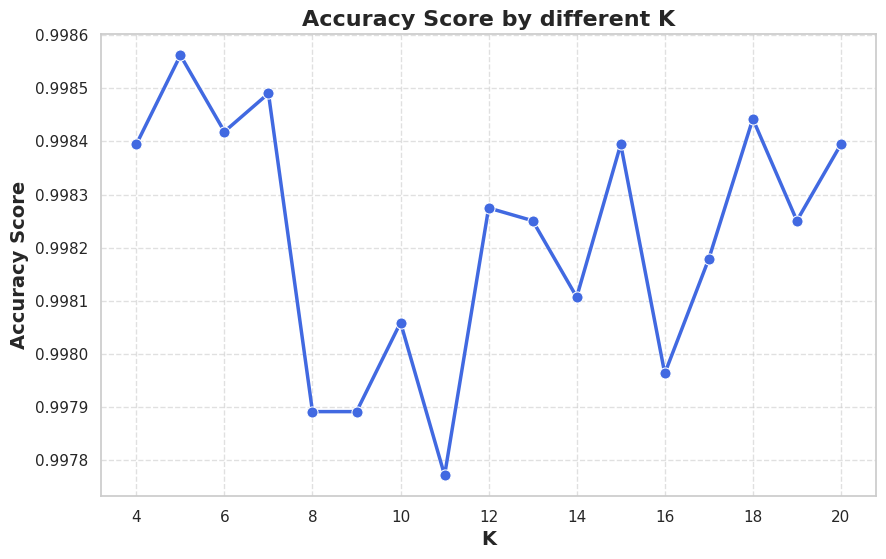

In [10]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,6))

sns.lineplot(
    data=scores_df,x="K",y="Score", marker='o',linewidth=2.5,markersize=8,color='royalblue'
)

plt.xlabel("K", fontsize=14, fontweight='bold')
plt.ylabel("Accuracy Score", fontsize=14, fontweight='bold')

plt.title("Accuracy Score by different K", fontsize=16, fontweight='bold')

plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

As we can see from the table and plot above every K, we tried, gives us excellent accuracy that is higher than 85%,  
so we can use every K in range 4..20 (we start from n+1, where n is classes amount). Let's choose 5 because it has the best score.  

**Getting the final accuracy score for the data split at the beginning**

In [11]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train_scaled, y_train)
y_pred = knn.predict(x_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print_green_cyan_colored_pair("Accuracy:", accuracy)

Accuracy: 0.9983568396549364


**Doing cross-validation with 3 blocks on final model**

In [12]:
final_cv_scores = cross_val_score(knn, x_scailed, y, cv=KFold(n_splits=3,shuffle=True))
for i, score in enumerate(final_cv_scores):
    print_green_cyan_colored_pair(f"Score {i+1}:",score)
print_green_cyan_colored_pair("Mean score", final_cv_scores.mean())

Score 1: 0.9983466321615987
Score 2: 0.998490294751977
Score 3: 0.9992810927390366
Mean score 0.9987060065508708


**Visualizing decision boundary as in previous Task3**  
  
Useful post: https://stackoverflow.com/questions/45075638/graph-k-nn-decision-boundaries-in-matplotlib  

In [13]:
h = 0.02

x_min, x_max = x.iloc[:, 0].min() - 1, x.iloc[:, 0].max() + 1
y_min, y_max = x.iloc[:, 1].min() - 1, x.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
mesh_points = np.c_[xx.ravel(), yy.ravel()]
mesh_points_df = pd.DataFrame(mesh_points, columns=x.columns)
Z = knn.predict(scaler.transform(mesh_points_df))
Z = Z.reshape(xx.shape)

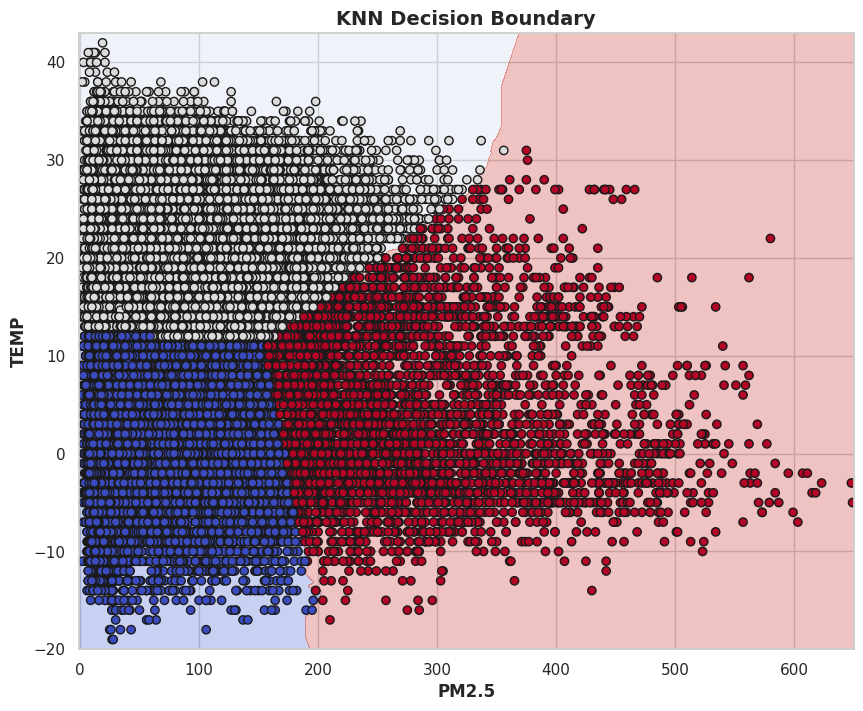

In [14]:
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.3)
plt.scatter(x.iloc[:, 0], x.iloc[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
plt.xlabel('PM2.5', fontweight="bold", fontsize=12)
plt.ylabel('TEMP', fontweight="bold", fontsize=12)
plt.title('KNN Decision Boundary', fontweight="bold", fontsize=14)
plt.show()

### **Summary**

**In this task, we practically used the K-nearest neighbors method to classify the dataset that we used in the previous tasks.  
First, we tried to find a K in the range 4..20 (we started with n+1, where n is the number of classes), which gives us an accuracy score of more than 85%.  
In this case, we could have used any K in this range, but we decided to choose 5 because it gave the best score and would also be faster compared to other options with a close but lower score, such as 12, 15 or 17, etc., due to the fewer calculations. 
Then, we tried to use a model with K=5, fitted on 65% of the dataset, to check the score on 35% of the test part.  
And finally, we performed cross-validation with 3 folds, which also gave us a high score, almost similar to the predicted test part score.**